In [44]:
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import pickle

In [45]:
height = 1080
width = 1920
channels = 3
scale_factor = 0.2
scaled_height = int(height * scale_factor)
scaled_width = int(width * scale_factor)
input_shape = (scaled_height, scaled_width, channels)
batch_size = 16
epochs = 50
training_dir = 'data/training/'
validation_dir = 'data/validation/'

def image_count(directory):
    dir_abs_path = os.path.join(os.getcwd(), directory)
    count = 0
    for name in os.listdir(dir_abs_path):
        if os.path.isfile(os.path.join(dir_abs_path, name)):
            count += 1
    return count

num_training_samples = image_count(training_dir + 'train/') + image_count(training_dir + 'no_train/')
num_validation_samples = image_count(validation_dir + 'train/') + image_count(validation_dir + 'no_train/')

print("Scaled height: {}".format(scaled_height))
print("Scaled width: {}".format(scaled_width))
print("Input shape: {}".format(input_shape))
print("Batch size: {}".format(batch_size))
print("# epochs: {}".format(epochs))
print("# training samples: {}".format(num_training_samples))
print("# validation samples: {}".format(num_validation_samples))

Scaled height: 216
Scaled width: 384
Input shape: (216, 384, 3)
Batch size: 16
# epochs: 50
# training samples: 3013
# validation samples: 749


In [46]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    
    return model

# Instantiate the model
model = create_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 214, 382, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 107, 191, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 107, 191, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 105, 189, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 52, 94, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 52, 94, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 92, 64)       

In [50]:
# Set up training and validation data
training_datagen = ImageDataGenerator(rescale  =  1./255,
#                                       rotation_range = 40,
#                                       width_shift_range = 0.2,
#                                       height_shift_range = 0.2,
#                                       shear_range = 0.2,
#                                       zoom_range = 0.2,
#                                       horizontal_flip = True,
#                                       fill_mode = 'nearest'
                                     )

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_generator = training_datagen.flow_from_directory(
        'data/training/',
        target_size=(scaled_height, scaled_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        'data/validation/',
        target_size=(scaled_height, scaled_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 3013 images belonging to 2 classes.
Found 749 images belonging to 2 classes.


In [53]:
class HistoryRecorder(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.accuracy = []
        self.val_loss = [] 
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_accuracy.append(logs.get('val_accuracy'))
    
    def as_dict(self):
        return {'loss': self.loss, 'accuracy': self.accuracy, 'val_loss': self.val_loss, 'val_accuracy': self.val_accuracy}
        
class BestEpochRecorder(Callback):
    def on_train_begin(self, logs={}):
        self.started = False
        self.best_val_loss = 0.0
        self.best_epoch = 1
    
    def on_epoch_end(self, epoch, logs={}):
        epoch_val_loss = logs.get('val_loss')
        if epoch_val_loss < self.best_val_loss or not self.started:
            self.started = True
            self.best_val_loss = epoch_val_loss
            self.best_epoch = epoch
    
    def as_dict(self):
        return {'started': self.started, 'best_val_loss': self.best_val_loss, 'best_epoch': self.best_epoch}

history_recorder = HistoryRecorder()
best_epoch_recorder = BestEpochRecorder()
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True),
             ModelCheckpoint(filepath = 'train_detection_cnn', monitor = 'val_loss', save_best_only = True),
             history_recorder,
             best_epoch_recorder]

In [54]:
# Train the model over several epochs and save the results from the best epoch
# TODO: Read about and implement CLR, seems like it's getting stuck at a local minimum...taking out
# data augmentation for now to see if that avoids this saddling
model.fit_generator(
    training_generator,
    steps_per_epoch = num_training_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = num_validation_samples // batch_size)

Epoch 1/50
188/188 [==============================] - 101s 538ms/step - loss: 0.5270 - accuracy: 0.7451 - val_loss: 0.4776 - val_accuracy: 0.8505
Epoch 2/50
188/188 [==============================] - 111s 591ms/step - loss: 0.4301 - accuracy: 0.8195 - val_loss: 0.3619 - val_accuracy: 0.9443
Epoch 3/50
188/188 [==============================] - 114s 606ms/step - loss: 0.3419 - accuracy: 0.8755 - val_loss: 0.2635 - val_accuracy: 0.9647
Epoch 4/50
188/188 [==============================] - 118s 629ms/step - loss: 0.2663 - accuracy: 0.8972 - val_loss: 0.2177 - val_accuracy: 0.9647
Epoch 5/50
188/188 [==============================] - 134s 715ms/step - loss: 0.2351 - accuracy: 0.9149 - val_loss: 0.1764 - val_accuracy: 0.9606
Epoch 6/50
188/188 [==============================] - 128s 683ms/step - loss: 0.2016 - accuracy: 0.9283 - val_loss: 0.1500 - val_accuracy: 0.9742
Epoch 7/50
188/188 [==============================] - 125s 666ms/step - loss: 0.1750 - accuracy: 0.9359 - val_loss: 0.1304 -

In [56]:
# Save the training history and best epoch stats (the epoch index and its associated val loss)
print("Best epoch: {}".format(best_epoch_recorder.best_epoch))
print("Val loss: {}".format(best_epoch_recorder.best_val_loss))

history_dict        = history_recorder.as_dict()
best_epoch_dict     = best_epoch_recorder.as_dict()
history_filename    = 'history.p'
best_epoch_filename = 'best_epoch.p'
history_file        = open(history_filename, 'wb')
best_epoch_file     = open(best_epoch_filename, 'wb')
pickle.dump(history_dict, history_file)
pickle.dump(best_epoch_dict, best_epoch_file)
history_file.close()
best_epoch_file.close()

Best epoch: 14
Val loss: 0.08662302515599747


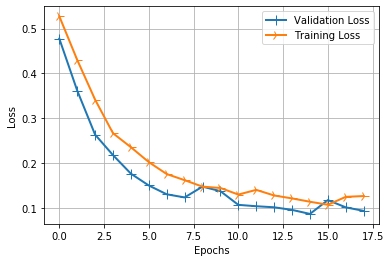

In [57]:
# Plot loss curves
epochs_array = np.arange(len(history_recorder.loss))
loss_values = history_recorder.loss
val_loss_values = history_recorder.val_loss
line1 = plt.plot(epochs_array, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs_array, loss_values, label='Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

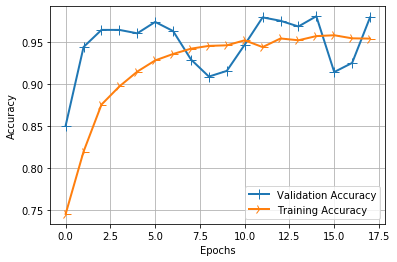

In [58]:
# Plot accuracy curves
acc_values = history_recorder.accuracy
val_acc_values = history_recorder.val_accuracy
line1 = plt.plot(epochs_array, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs_array, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [59]:
y_true = validation_generator.classes
y_pred = model.predict_generator(validation_generator).flatten()
class_idx_dict = validation_generator.class_indices
print('Class index for \'no_train\' is {}.'.format(class_idx_dict['no_train']))
print('Class index for \'train\' is {}.'.format(class_idx_dict['train']))

Class index for 'no_train' is 0.
Class index for 'train' is 1.


In [60]:
# TODO: eventually don't use path, use preloaded image
LAYER_NAME = 'conv2d_8'
def create_grad_cam_heatmap(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(scaled_height, scaled_width))
    img = tf.keras.preprocessing.image.img_to_array(img)
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])
    grad_model.layers[-1].activation = None
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        score = predictions[:, 0]

    output = conv_outputs[0]
    grads = tape.gradient(score, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (scaled_width, scaled_height))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    output_image_bgr = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)
    output_image_rgb = output_image_bgr[:,:,::-1]
    
    return output_image_rgb

Model said train/mdp-20191116_095827_31F4-0007.jpg did not contain a train (0.27868595719337463), but it did:


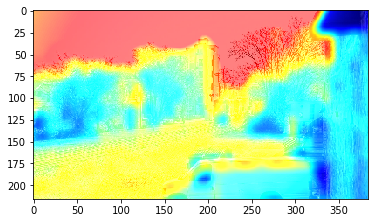

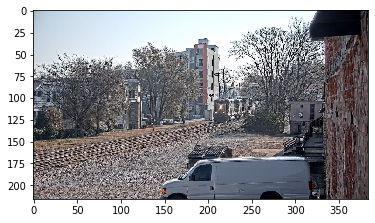

Model said train/mdp-20191116_095827_31F4-0008.jpg did not contain a train (0.30147817730903625), but it did:


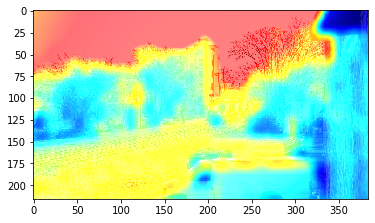

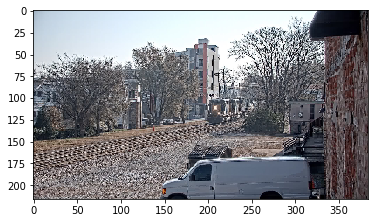

Model said train/mdp-20191116_095827_31F4-0009.jpg did not contain a train (0.3253486752510071), but it did:


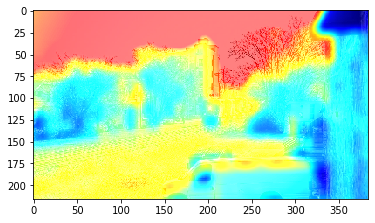

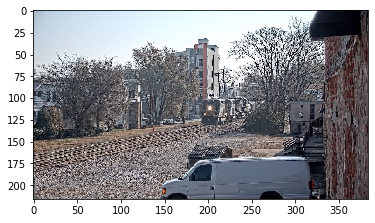

Model said train/mdp-20191116_095827_31F4-0013.jpg did not contain a train (0.28587377071380615), but it did:


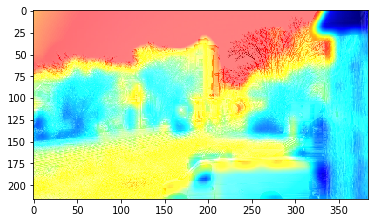

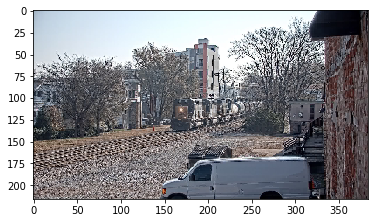

Model said train/mdp-20191116_095827_31F4-0040.jpg did not contain a train (0.4430462121963501), but it did:


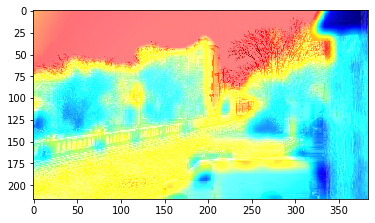

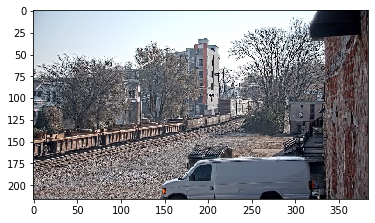

Model said train/mdp-20191116_095827_31F4-0041.jpg did not contain a train (0.4534057378768921), but it did:


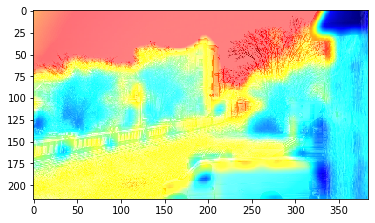

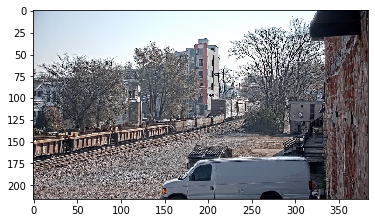

Model said train/mdp-20191116_095827_31F4-0045.jpg did not contain a train (0.28412073850631714), but it did:


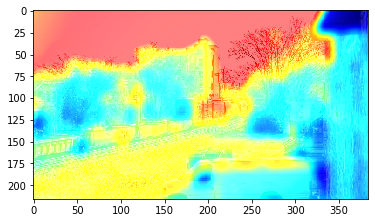

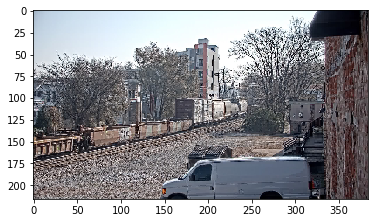

Model said train/mdp-20191116_111507_B5E6-0101.jpg did not contain a train (0.1990308165550232), but it did:


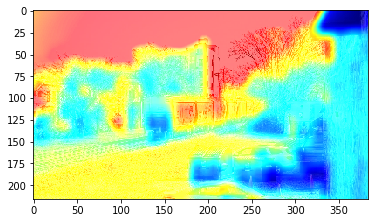

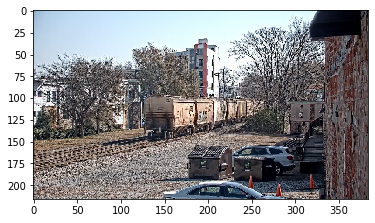

Model said train/mdp-20191116_122653_D272-0036.jpg did not contain a train (0.22714358568191528), but it did:


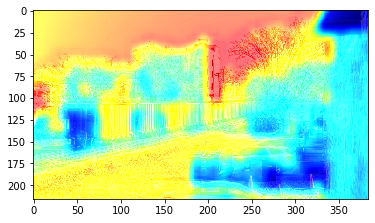

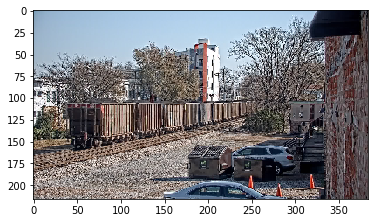

Model said train/mdp-20191116_122653_D272-0041.jpg did not contain a train (0.3282516300678253), but it did:


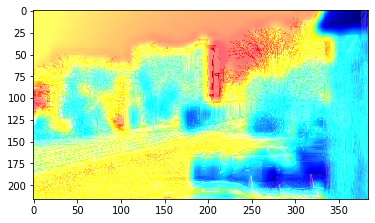

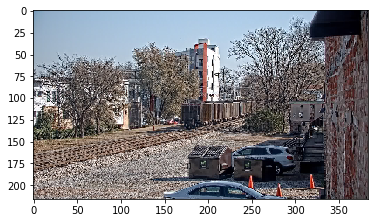

Model said train/mdp-20191116_141948_B423-0008.jpg did not contain a train (0.26197218894958496), but it did:


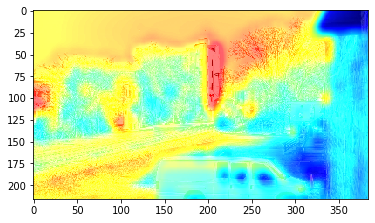

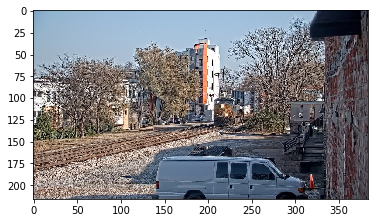

Model said train/mdp-20191116_151621_C0EE-0056.jpg did not contain a train (0.34058624505996704), but it did:


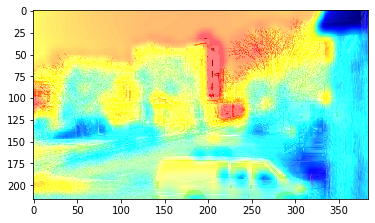

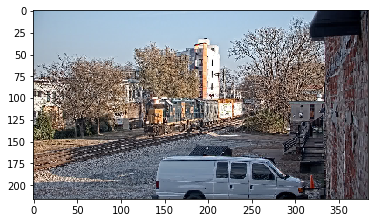

Model said train/mnp-20191116_021630_619C-0008.jpg did not contain a train (0.1163405179977417), but it did:


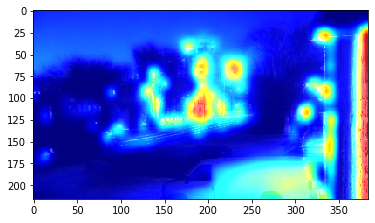

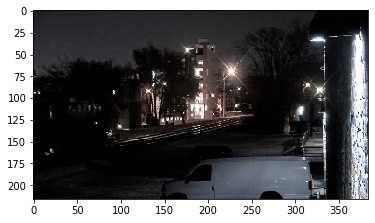

Model said train/mnp-20191116_205714_77D3-0009.jpg did not contain a train (0.13060781359672546), but it did:


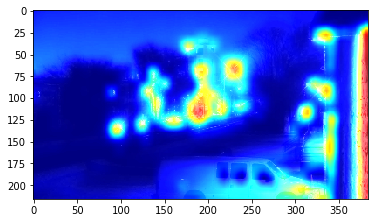

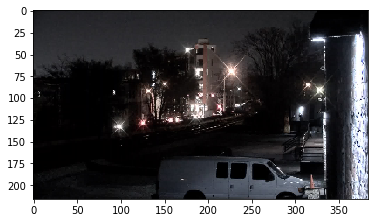

Misclassified 14 images.


In [61]:
# Round to nearest class label (1 "train" or 0 "no_train")
pred_class_idxs = np.around(y_pred)
filenames = validation_generator.filenames
miss_count = 0
for i in range(num_validation_samples):
    if int(pred_class_idxs[i]) != y_true[i]:
        miss_count += 1
        if y_true[i] == class_idx_dict['no_train']:
            print('Model said {} contained a train ({}), but it didn\'t:'.format(filenames[i], y_pred[i]))
        else:
            print('Model said {} did not contain a train ({}), but it did:'.format(filenames[i], y_pred[i]))
        batch_number = i // batch_size
        img_number = i % batch_size
        img = validation_generator[batch_number][0][img_number]
        img_heatmap = create_grad_cam_heatmap('data/validation/' + filenames[i])
        plt.imshow(img_heatmap)
        plt.show()
        plt.imshow(img)
        plt.show()

print('Misclassified {} images.'.format(miss_count))


In [62]:
cm = confusion_matrix(y_true, pred_class_idxs)
print('Confusion Matrix:')
print(cm)
true_negatives = cm[0][0]
false_negatives = cm[1][0]
true_positives = cm[1][1]
false_positives = cm[0][1]
print('True negatives: {}'.format(true_negatives))
print('False negatives: {}'.format(false_negatives))
print('True positives: {}'.format(true_positives))
print('False positives: {}'.format(false_positives))

Confusion Matrix:
[[190   0]
 [ 14 545]]
True negatives: 190
False negatives: 14
True positives: 545
False positives: 0
